# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

>4A8AB5<0  W i n d o w s   4;O  L i n u x   =5  8<55B  CAB0=>2;5==KE  48AB@81CB82>2. 
 
 
 
 >A?>;L7C9B5AL  :><0=4>9  " w s l . e x e   - - l i s t   - - o n l i n e "   4;O  ?5@5G8A;5=8O  4>ABC?=KE  48AB@81CB82>2
 
 8  :><0=4>9  " w s l . e x e   - - i n s t a l l   < D i s t r o > "   4;O  CAB0=>2:8. 
 
 
 
 8AB@81CB82K  B0:65  <>6=>  CAB0=>28BL  87  M i c r o s o f t   S t o r e : 
 
 h t t p s : / / a k a . m s / w s l s t o r e 
 
 E r r o r   c o d e :   B a s h / S e r v i c e / C r e a t e I n s t a n c e / G e t D e f a u l t D i s t r o / W S L _ E _ D E F A U L T _ D I S T R O _ N O T _ F O U N D 
 
 


C:\Users\aa\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Изменение режима для потока после его установки невозможно
  warnings.warn(str(err))


lets go
state vector dim = 4
n_actions = 2


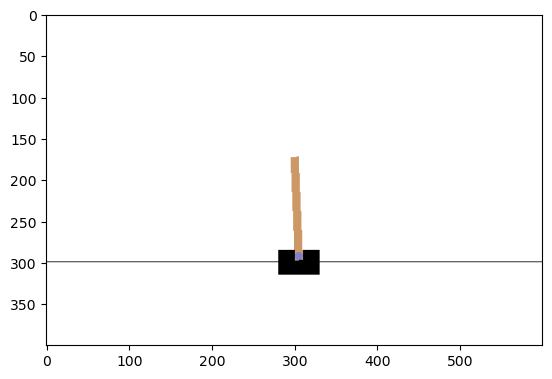

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

state = env.render(mode="rgb_array")
print("lets go")

plt.imshow(env.render(mode="rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [2]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [3]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([env.state])
        probs = np.reshape(probs, env.action_space.n)
        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(a=range(env.action_space.n), p=probs)
        # ^-- hint: try np.random.choice
        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [4]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.01948501 -0.02803142  0.0073269   0.03394965]
 [-0.02004564 -0.22325766  0.0080059   0.32893527]
 [-0.02451079 -0.0282506   0.0145846   0.03878773]
 [-0.02507581 -0.22357862  0.01536036  0.33603632]
 [-0.02954738 -0.41891578  0.02208108  0.6335232 ]]
actions: [0, 1, 0, 0, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [5]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    bound = np.quantile(np.array(rewards_batch), percentile / 100)
    elite_array = [[state, action] for state, action, reward in zip(states_batch, actions_batch, rewards_batch) if reward > bound]

    
    elite_states = [x[0] for x in elite_array]
    elite_states = np.array([x for y in elite_states for x in y])
    elite_actions = [x[1] for x in elite_array]
    elite_actions = np.array([x for y in elite_actions for x in y])
    
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [6]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 196.200, threshold=205.300


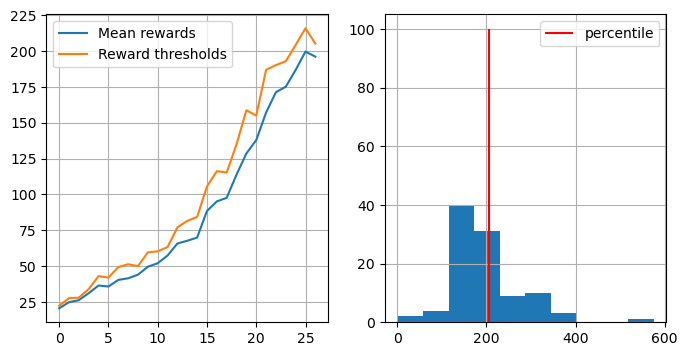

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [7]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
    print("elite_states = ", elite_actions)
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [8]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

In [9]:
import sys

In [10]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [11]:
import gym
import numpy as np
import matplotlib.pyplot as plt
env = gym.make("Taxi-v3").env

env.reset()
n_actions = env.action_space.n
# state_dim = env.observation_space

# state = env.render(mode="rgb_array")
print("lets go")

# plt.imshow(env.render(mode="rgb_array"))
# print("state vector dim =", state_dim)
print("n_actions =", n_actions)

lets go
n_actions = 6


In [12]:
n_states = 500

In [13]:
def generate_session_for_taxi(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])
        probs = np.reshape(probs, env.action_space.n)
        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(a=range(env.action_space.n), p=probs)
        # ^-- hint: try np.random.choice
        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [14]:
class drive:
    def __init__(self, n_states, n_actions, gamma = 0.9):
        self.probas = np.zeros((n_states, n_actions)) + 1 / n_actions
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma 
    def predict_proba(self, state):
        return self.probas[state]
    def update_probas(self, elite_states, elite_actions):
        probas = np.zeros((self.n_states, self.n_actions))
        for state, action in zip(elite_states, elite_actions):
            probas[state][action] += 1
        s = np.sum(probas, axis = 1)
        for i in range(n_states):
            if s[i]:
                self.probas[i] = self.gamma * self.probas[i] + (1 - self.gamma) * probas[i] / s[i]
        

In [15]:

def reward_driver(n_sessions, percentile):
    agent = drive(500, 6)
    rewards_batch = np.zeros(1)
    for _ in range(100):
        # generate new sessions
        sessions = [generate_session_for_taxi(env, agent) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
        agent.update_probas(elite_states, elite_actions)
       
    return np.mean(rewards_batch)



In [95]:
performance = {}
for n_sessions in range(50, 250, 25):
    for percentile in range(50, 100, 10):
        performance[n_sessions, percentile] = reward_driver(n_sessions, percentile)
        print("n_sessions, precentile = ", n_sessions, percentile, "answer = ", performance[n_sessions, percentile])


C:\Users\aa\AppData\Local\Temp\ipykernel_14412\94765648.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))


n_sessions, precentile =  50 50 answer =  -3.42
n_sessions, precentile =  50 60 answer =  -0.02
n_sessions, precentile =  50 70 answer =  -1.66
n_sessions, precentile =  50 80 answer =  0.24
n_sessions, precentile =  50 90 answer =  0.56
n_sessions, precentile =  75 50 answer =  1.6
n_sessions, precentile =  75 60 answer =  1.8133333333333332
n_sessions, precentile =  75 70 answer =  2.1333333333333333
n_sessions, precentile =  75 80 answer =  1.3866666666666667
n_sessions, precentile =  75 90 answer =  2.7733333333333334
n_sessions, precentile =  100 50 answer =  2.81
n_sessions, precentile =  100 60 answer =  5.12
n_sessions, precentile =  100 70 answer =  2.77
n_sessions, precentile =  100 80 answer =  4.51
n_sessions, precentile =  100 90 answer =  4.53
n_sessions, precentile =  125 50 answer =  3.496
n_sessions, precentile =  125 60 answer =  4.952
n_sessions, precentile =  125 70 answer =  3.192
n_sessions, precentile =  125 80 answer =  4.312
n_sessions, precentile =  125 90 ans

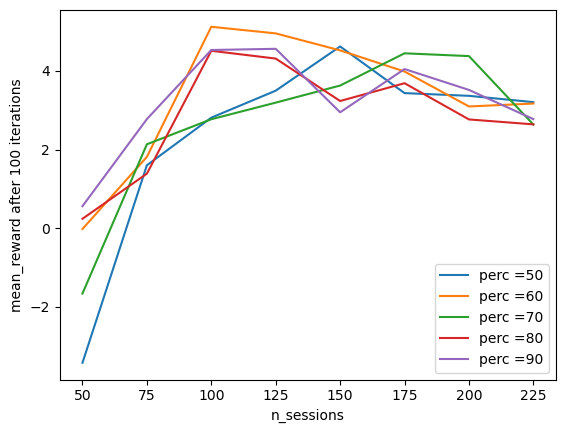

In [98]:
for y in range(50, 100, 10):
    plt.plot(np.arange(50, 250, 25), np.array([performance[x] for x in performance if x[1] == y]), label = "perc =" + str(y))
plt.xlabel("n_sessions")
plt.ylabel("mean_reward after 100 iterations")
plt.legend()
plt.show()

**В клетке ниже получили positive average score**

mean reward = 3.680, threshold=8.000


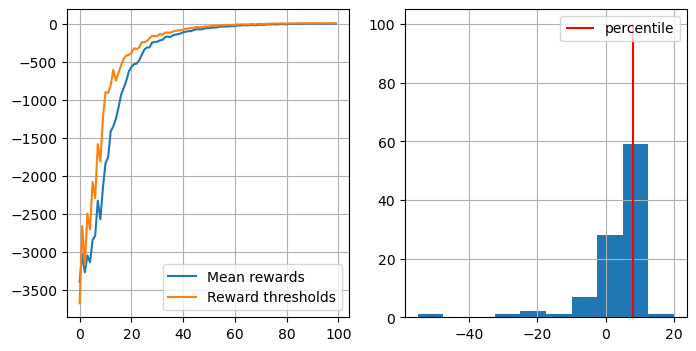

In [16]:
n_sessions = 100
percentile = 70
log = []
agent = drive(500, 6)
for i in range(100):
    # generate new sessions
    sessions = [generate_session_for_taxi(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
    agent.update_probas(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 20])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

```<Describe what you did here>```

**Запустил алгоритм с разными значениями percentile и n_sessions. Посмотрел, какой эффектиновсти они добиваются за 100 итераций, нарисовал график** 

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

lets go
state vector dim = 2
n_actions = 3


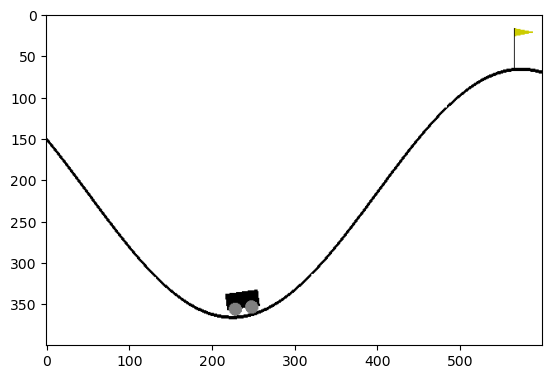

In [14]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("MountainCar-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

state = env.render(mode="rgb_array")
print("lets go")

plt.imshow(env.render(mode="rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

**Тут в двух клеткахниже сделано задание получить mean reward $\geq -150$**

In [40]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50))

mean reward = -137.260, threshold=-113.000


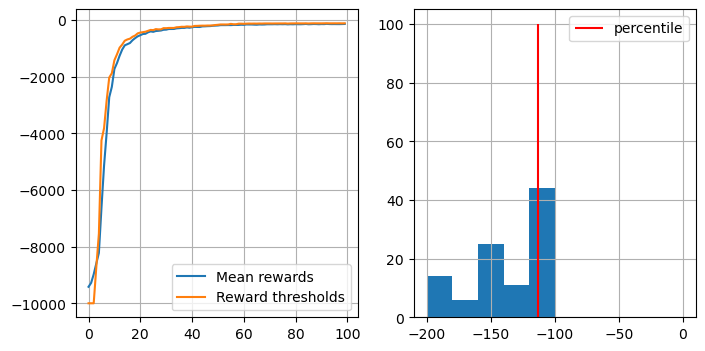

In [32]:
n_sessions = 100
percentile = 80
log = []

for i in range(100):
    # generate new sessions
    
    sessions = [generate_session(env, agent, t_max=10000) for _ in range(n_sessions)]
    print(i)
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 0])

    if np.mean(rewards_batch) > -100:
        print("You Win! You may stop training now via KeyboardInterrupt.")

**Тут добавлен joblib и переиспользование предыдущих сессий**

In [128]:
def generate_session_for_car(agent):
    env = gym.make("MountainCar-v0").env
    env.reset()
    return generate_session(env, agent, t_max = 10000)

In [129]:
from joblib import Parallel, delayed

In [147]:
from sklearn.neural_network import MLPClassifier
def find_nn():
    env = gym.make("MountainCar-v0").env
    env.reset()
    n_actions = env.action_space.n
    state_dim = env.observation_space.shape[0]
    local_agent = MLPClassifier(
        hidden_layer_sizes=(50, 50, 50),
        activation='tanh',
    )
    local_agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
    n_sessions = 100
    percentile = 80
    log = []
    prev_sessions = []
    sessions_memory = []
    
    for i in range(1000):
        # generate new sessions
        sessions = Parallel(n_jobs = 6)(delayed(generate_session_for_car)(local_agent) for _ in range(n_sessions))
        
        sessions_memory = sessions.copy()
        if len(prev_sessions):
            sessions += prev_sessions
            
#         print(i, "sessions = ", len(sessions), "sessions_memory =", len(sessions_memory))
        states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

        
        local_agent.partial_fit(elite_states, elite_actions)
        show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 0])
        
        prev_sessions = sessions_memory + prev_sessions
        if i >= 3:
            prev_sessions = prev_sessions[:-n_sessions]
#         print(i, " len_prev =", len(prev_sessions))
        
    return local_agent


mean reward = -129.023, threshold=-89.000


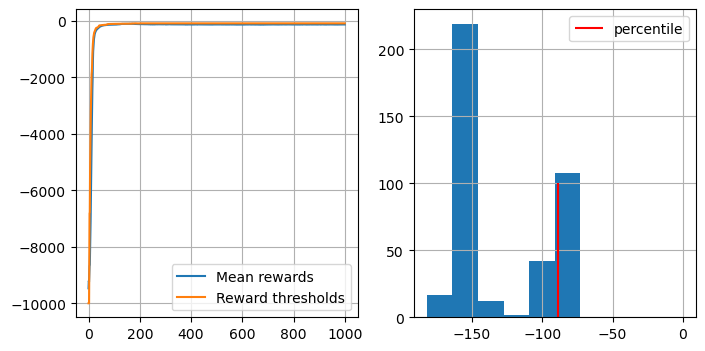

In [148]:
# new_agent = find_nn()
from joblib import Parallel, delayed
hitman_agent_47 = find_nn() 

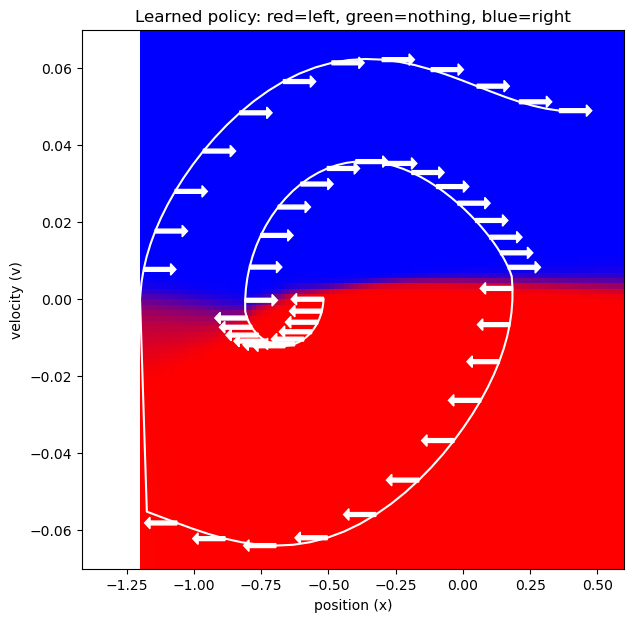

In [150]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    
    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')
    
    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')
    
    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)

with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, hitman_agent_47)

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.